In [1]:
import sys
sys.path.append('../../..')

from olfactory_navigation import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.simulation import run_test, SimulationHistory
from olfactory_navigation.test_setups import run_all_starts_test

from olfactory_navigation.agents.model_based_util.pomdp import Model
from olfactory_navigation.agents.model_based_util.belief import Belief, BeliefSet
from olfactory_navigation.environment import _resize_array

from matplotlib import pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

import pandas as pd
import numpy as np
import cupy as cp
import h5py
import os

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(2)

## Parameters

In [3]:
agent_speed = 4 # cm/s
dt = 0.5 # s
multiplier = agent_speed * dt
actual_tank_size = np.array([90,114]) # actual size: 90cm x 114cm but it is scaled by a walking speed of <multiplier>
tank_size = (actual_tank_size / multiplier).astype(int)
space_shape = (tank_size * 2) + 1

source_position = tank_size

goal_radius = 1
# odor_radius = 10.5
odor_radius = 3 / multiplier # 3 cm * 0.8 -> 3.75 grid units

In [4]:
# Odor variables
thresh = 3e-2

base_odor_plume_file = '../plume_average_computation/average_odor_base_3e2.npy'
odor_fields_folder = '/storage/arnaud/tank_odor_field_2024_06_13/'

## Building POMDP Model

In [5]:
# Legs odor field
odor_field = np.zeros(space_shape)
odor_field_indices = np.array(list(np.ndindex(tuple(space_shape))))

in_odor_plume = np.sum((odor_field_indices - tank_size[None,:])**2, axis=1) <= (odor_radius ** 2)
odor_field[*odor_field_indices[in_odor_plume].T] = 1.0

In [6]:
# Gathering nose odor plume
average_odor_plume = np.load(base_odor_plume_file)

odor_shape = np.array([408, 488])
odor_center = np.array([500, 500])

lower_bound = odor_center - (odor_shape / 2).astype(int)
upper_bound = odor_center + (odor_shape / 2).astype(int)
slices = [slice(lb, ub) for lb, ub in zip(lower_bound, upper_bound)]

average_odor_plume = average_odor_plume[*slices]

assert all(average_odor_plume.shape == odor_shape)

In [7]:
# Nose odor field
tank_average_odor_plume = _resize_array(average_odor_plume, tank_size, 'linear')

# Putting odor plume average in
nose_odor_field = np.zeros(odor_field.shape)
lower_bounds, upper_bounds = (tank_size/2).astype(int), (tank_size/2).astype(int) + tank_size
nose_odor_field[*[slice(lb, ub) for lb, ub in zip(lower_bounds, upper_bounds)]] = tank_average_odor_plume

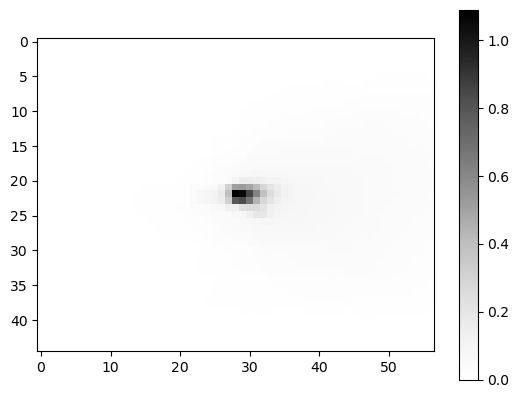

In [8]:
plt.imshow(tank_average_odor_plume, cmap='Greys')
plt.colorbar()
plt.show()

In [9]:
thresholds = np.array([-np.inf,1,2,np.inf])
action_set = np.array([
    [-1,  0], # North
    [ 0,  1], # East
    [ 1,  0], # South
    [ 0, -1]  # West
])
action_labels = [
    'North',
    'East',
    'South',
    'West'
]

In [10]:
# Base Model parameters
state_count = np.prod(space_shape)

state_grid = [[f's_{x}_{y}' for x in range(space_shape[1])] for y in range(space_shape[0])]
end_states = np.argwhere(np.fromfunction(lambda x,y: ((x-source_position[0])**2 + (y-source_position[1])**2) <= goal_radius**2,
                                            shape=space_shape).ravel())[:,0].tolist()

# Counts
action_count = len(action_set)
observation_count = thresholds.shape[-1] # Thresholds minus 1; plus 1 for the goal.

# Building observation matrix
observations = np.empty((state_count, action_count, observation_count), dtype=float)

filt_nose_odor_field = nose_odor_field.ravel()
filt_nose_odor_field[odor_field.ravel() > 0.0] = 0.0

observations[:,:,1] = filt_nose_odor_field[:,None] # Nose
observations[:,:,2] = odor_field.ravel()[:,None] # Nose AND legs
observations[:,:,0] = 1.0 - observations[:,:,1] - observations[:,:,2] # Nothing

# Goal observation
observations[:,:,-1] = 0.0
observations[end_states,:,:] = 0.0
observations[end_states,:,-1] = 1.0

# Assert observations sum to 1
assert np.all(np.sum(observations, axis=2) == 1.0), "Observation table malformed, something is wrong..."

# Observation labels
observation_labels = ['nothing', 'something_nose', 'something_nose_legs', 'goal']

# Compute reachable states
points = np.array(np.unravel_index(np.arange(np.prod(space_shape)), space_shape)).T

# For each actions compute all new grid points (using the environment.move method)
action_new_states = []
movements = action_set
for move_vector in movements:

    # Applying the movement vector
    new_points = points + move_vector

    # Wrap points
    new_points = np.where(new_points < 0, (new_points + space_shape[None,:]), new_points)
    new_points = np.where(new_points >= space_shape[None,:], (new_points - space_shape[None,:]), new_points)

    new_states = np.ravel_multi_index((new_points[:,0], new_points[:,1]), dims=space_shape)
    action_new_states.append(new_states)

# Forming it the reachable states array from the new states for each action
reachable_states = np.array(action_new_states).T[:,:,None]

# Instantiate the model object
model = Model(
    states = state_grid,
    actions = action_labels,
    observations = observation_labels,
    reachable_states = reachable_states,
    observation_table = observations,
    end_states = end_states
)

## Building Environment

In [11]:
odor_field_files = os.listdir(odor_fields_folder)
odor_field_environments = []
odor_field_source_pos = []

for file_i, file in enumerate(odor_field_files):
    print(f'[{file_i+1}/{len(odor_field_files)}] Loading odor field: {odor_fields_folder}{file}')

    # Loading data
    data = h5py.File(odor_fields_folder + file, 'r')

    # Finding out start and end times
    time_slices = data['odor_base']
    time_slices = sorted([int(key_name) for key_name in time_slices.keys()])

    start_time = min(time_slices)
    end_time = max(time_slices)

    # Gathering data
    odor = data['odor_base']
    odor_data = [odor[str(time)] for time in range(start_time, end_time)]
    odor_data_array = np.array(odor_data)

    # Resizing the data array
    new_odor_data_array = np.zeros((len(odor_data_array), *tank_size))
    for i, data_slice in enumerate(odor_data_array):
        new_odor_data_array[i] = _resize_array(data_slice,
                                               new_shape=tank_size,
                                               interpolation='linear')

    # compute the odor source position
    source_pos = np.unravel_index(np.argmax(new_odor_data_array[0]), shape=new_odor_data_array[0].shape)

    # Centering the odor field
    centered_odor_data_array = np.zeros((len(odor_data_array), *space_shape))
    for i, data_slice in enumerate(new_odor_data_array):
        centered_odor_data_array[i,
                                (tank_size[0] - source_pos[0]) : (tank_size[0] - source_pos[0] + tank_size[0]),
                                (tank_size[1] - source_pos[1]) : (tank_size[1] - source_pos[1] + tank_size[1])] = data_slice

    # Filtering the odor field
    filt_odor_data_array = (centered_odor_data_array > thresh).astype(float)

    legs_odor = np.argwhere(odor_field > 0)
    for i in range(len(filt_odor_data_array)):
        filt_odor_data_array[i,*legs_odor.T] = 2.0

    # Setting up environment
    env = Environment(data_file = filt_odor_data_array,
                      data_source_position = tank_size,
                      source_radius = goal_radius,
                      boundary_condition = 'wrap')

    # Saving environment and source positions
    odor_field_environments.append(env)
    odor_field_source_pos.append(np.array(source_pos) / np.array(new_odor_data_array.shape[1:]))

[1/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/35_75.h5
[2/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/65_75.h5
[3/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/35_35.h5
[4/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/45_5.h5
[5/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/45_35.h5
[6/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/25_65.h5
[7/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/55_45.h5
[8/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/20_65.h5
[9/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/25_55.h5
[10/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/15_45.h5
[11/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/15_5.h5
[12/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/55_25.h5


## Agent Training

In [12]:
ag = FSVI_Agent(odor_field_environments[0],
                model=model,
                thresholds=[-np.inf, 1.0, 2.0, np.inf])

In [13]:
_ = ag.train(expansions=800,
             max_belief_growth=100,
             eps=1e-8,
             use_gpu=True)

[12/16/2024, 17:12:19] MDP_policy, not provided. Solving MDP with Value Iteration...
[12/16/2024, 17:12:19] Sending Model to GPU...
[12/16/2024, 17:12:19]     > Done in 0.191s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 10465-state, 4-action
  - Converged in 1000 iterations and 1.1091 seconds
  - Took on average 0.0011s per iteration


Expansions:   0%|          | 0/800 [00:00<?, ?it/s]

Memory full: Out of memory allocating 22,262,822,400 bytes (allocated so far: 71,143,699,968 bytes).
Returning value function and history as is...

Summary of Point Based Value Iteration run
  - Model: 10465 state, 4 action, 4 observations
  - Converged or stopped after 580 expansion steps and 579 backup steps.
  - Resulting value function has 16620 alpha vectors.
  - Converged in 394.4199s

  - Expand function took on average 0.1118s and yielded on average 7699.80 beliefs per iteration. (0.0000s/it/belief)
  - Backup function took on average 0.5692s and yielded on average 28.70 alpha vectors per iteration. (0.0002s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


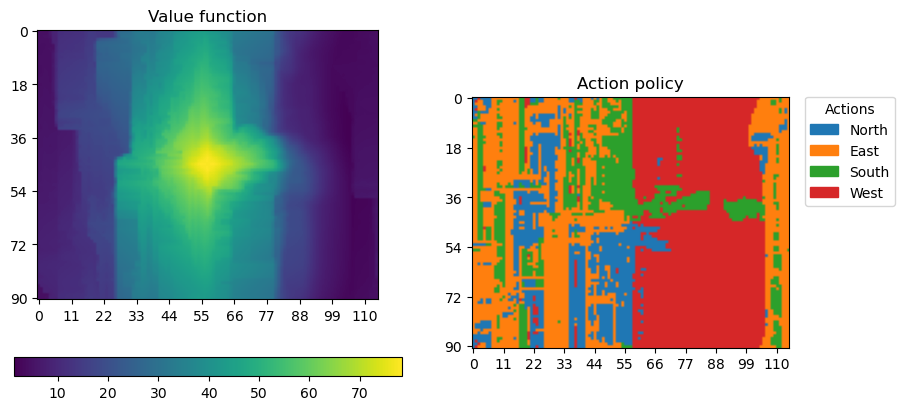

In [14]:
ag.value_function.plot()

## Run test

### Single point

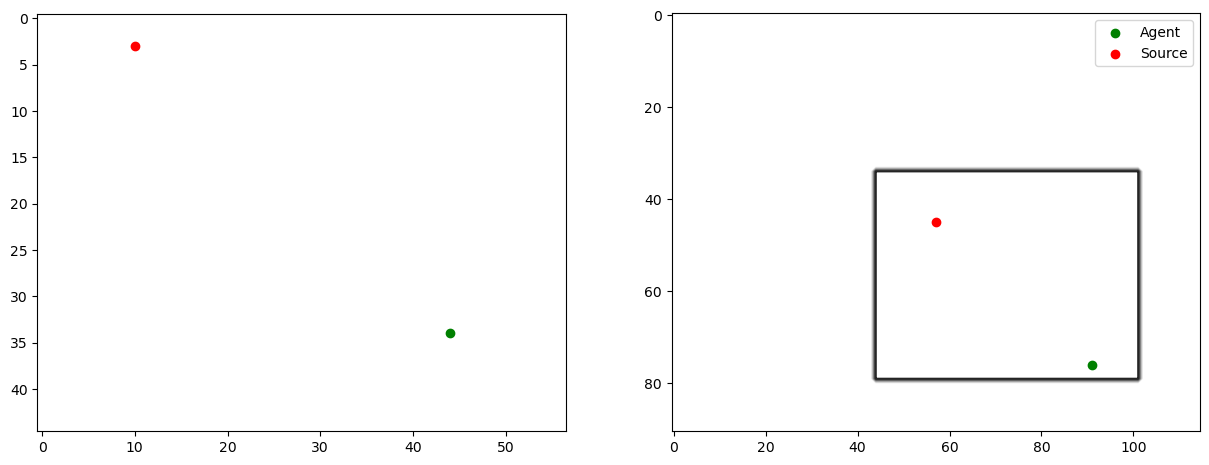

In [15]:
# PHYSICAL SPACE
source_point = (np.random.random(2) * tank_size).astype(int)
agent_start = (np.random.random(2) * tank_size).astype(int)

fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(15,10))

ax0.imshow(np.zeros(tank_size), cmap='Greys')
ax0.scatter(source_point[1], source_point[0], c='red', label='Source')
ax0.scatter(agent_start[1], agent_start[0], c='green', label='Agent')

# STATE SPACE
center_state = agent_start
agent_start_state = center_state + (tank_size - source_point)

belief = np.zeros(space_shape)
belief[center_state[0]:center_state[0]+tank_size[0]+1, center_state[1]:center_state[1]+tank_size[1]+1] = 1
belief /= np.sum(belief)

ax1.imshow(np.zeros(space_shape), cmap='Greys')
ax1.contour(belief, cmap='Greys')
# ax1.invert_yaxis()
ax1.scatter(agent_start_state[1], agent_start_state[0], c='green', label='Agent')
ax1.scatter(tank_size[1], tank_size[0], c='red', label='Source')
ax1.legend()

In [16]:
belief = BeliefSet(model=ag.model, beliefs=[Belief(model=ag.model, values=belief.ravel())])
hist = run_test(agent=ag,
                start_points=agent_start_state[None,:],
                initialization_values={'belief': belief},
                use_gpu=True)

Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 3.488s:
Simulations reached goal: 1/1 (0 failures (reached horizon: 0)) (100.00% success)
 - Average step count:                 572.000 +- 0.00 (Successful only: 572.000 +- nan)
 - Extra steps:                        508.000 +- 0.00 (Successful only: 508.000 +- nan)
 - Average discounted rewards (ADR):   0.003 +- 0.00 (Successful only: 0.003 +- nan)
 - Tmin/T:                             0.112 +- 0.00 (Successful only: 0.112 +- nan)


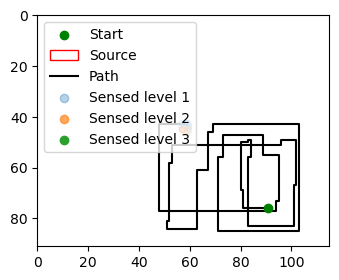

In [17]:
hist.plot()

### Experimental data

In [18]:
df = pd.read_csv('../experimental_data/experimental_positions.csv')

In [19]:
exp_source_indices = df[['y_food_cm','x_food_cm']].to_numpy().astype(float)
exp_agent_indices = df[['y0_cm', 'x0_cm']].to_numpy().astype(float)

exp_source_indices /= multiplier
exp_agent_indices /= multiplier

exp_source_indices = exp_source_indices.astype(int)
exp_agent_indices = exp_agent_indices.astype(int)

In [45]:
source_distances = []
odor_field_source_positions_in_tank = np.array(odor_field_source_pos) * tank_size

for source_pos in odor_field_source_positions_in_tank:
    source_distances.append(np.sum((exp_source_indices - source_pos) ** 2, axis=1) ** (1/2))

assigned_environment = np.argmin(np.array(source_distances), axis=0)

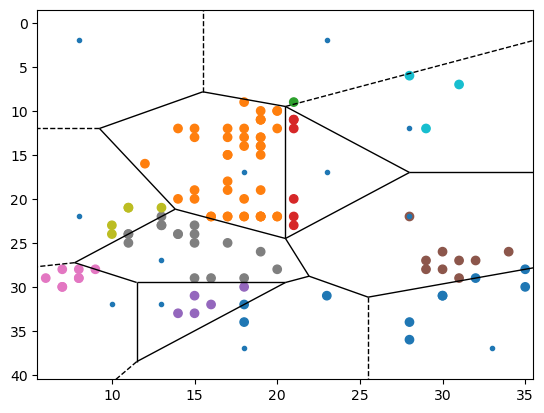

In [67]:
vor = Voronoi(odor_field_source_positions_in_tank[:,::-1])
fig = voronoi_plot_2d(vor, show_vertices=False)

plt.scatter(exp_source_indices[:,1], exp_source_indices[:,0], c=assigned_environment, cmap='tab10')
plt.gca().invert_yaxis()
plt.show()

In [69]:
# Generation of points
n = len(exp_source_indices)

# STATE SPACE
center_state = exp_agent_indices
agent_start_state = center_state + (tank_size[None,:] - exp_source_indices)

beliefs = []

for center, start in zip(center_state, agent_start_state):
    belief = np.zeros(space_shape)
    belief[center[0]:center[0]+tank_size[0]+1, center[1]:center[1]+tank_size[1]+1] = 1
    belief /= np.sum(belief)

    beliefs.append(belief.flatten())

beliefs = np.array(beliefs)

In [72]:
all_hist = []
for source_i, source_pos in enumerate(odor_field_source_positions_in_tank):
    print(f'[{source_i+1}/{len(odor_field_source_positions_in_tank)}] Environment {source_i}')

    is_assigned_model = (assigned_environment == source_i)
    env = odor_field_environments[source_i]

    if np.sum(is_assigned_model) == 0:
        continue

    belief = BeliefSet(ag.model, beliefs[is_assigned_model])
    hist = run_test(agent=ag,
                    start_points=agent_start_state[is_assigned_model],
                    environment=env,
                    initialization_values={'belief': belief},
                    use_gpu=True,
                    print_stats=False)

    all_hist.append(hist)

[1/12] Environment 0
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[2/12] Environment 1
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[3/12] Environment 2
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[4/12] Environment 3
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[5/12] Environment 4
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[6/12] Environment 5
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[7/12] Environment 6
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[8/12] Environment 7
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[9/12] Environment 8
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[10/12] Environment 9
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[11/12] Environment 10
[12/12] Environment 11
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

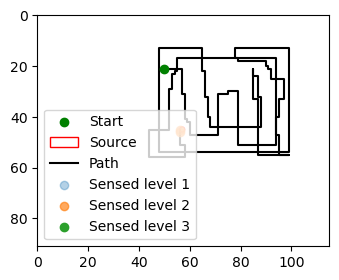

In [82]:
all_hist[5].plot()

In [74]:
comb_hist = all_hist[0]
for hist in all_hist[1:]:
    comb_hist += hist

In [75]:
print(comb_hist.summary)

ValueError: operands could not be broadcast together with shapes (1033,) (118,) 

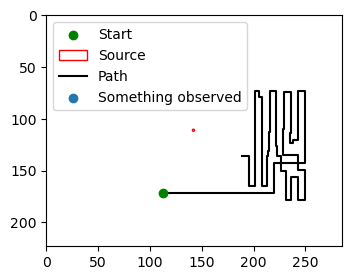

In [35]:
hist.plot()

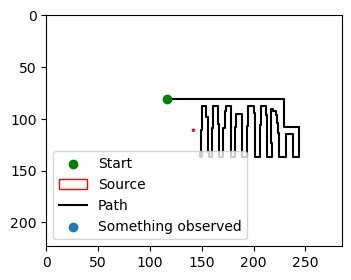

In [36]:
hist.plot(2)

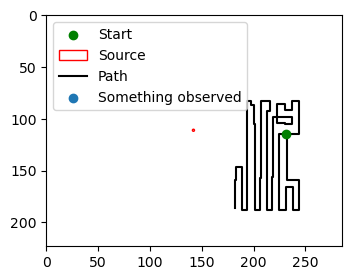

In [37]:
hist.plot(4)

In [34]:
hist.save()

Simulations saved to: ./Simulations-s_223_285-n_118-20241127_102129-horizon_1000.csv
Simulation's analysis saved to: ./Simulations-s_223_285-n_118-20241127_102129-horizon_1000-analysis.csv
